In [1]:
# 환경 설정
from mlwpy import *
%matplotlib inline

iris = datasets.load_iris()
(iris_train,     iris_test, 
 iris_train_tgt, iris_test_tgt) = skms.train_test_split(iris.data,
                                                        iris.target, 
                                                        test_size=.25)
# 열 이름에서 단위 `(cm)`을 제거합니다.
iris.feature_names = [fn[:-5] for fn in iris.feature_names]

# 편의를 위해 데이터프레임을 사용합니다. 
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]

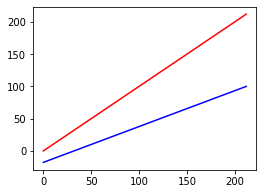

In [2]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
f_temps = np.linspace(0, 212, 100)
c_temps = (5/9) * (f_temps - 32)
plt.plot(f_temps, f_temps, 'r',  # F -> F
         f_temps, c_temps, 'b');  # F -> C

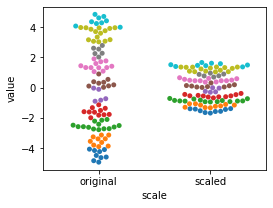

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
original = np.random.uniform(-5, 5, 100)
scaled = skpre.StandardScaler().fit_transform(original.reshape(-1,1))[:,0]
bins = np.floor(original).astype(np.uint8) + 5

df = pd.DataFrame({'original':original,
                   'scaled':scaled,
                   'hue':bins})
df = pd.melt(df, id_vars='hue', var_name='scale')

sns.swarmplot(x='scale', y='value', hue='hue', data=df).legend_.remove()

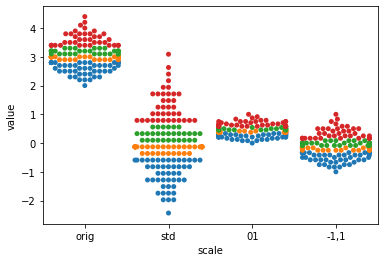

In [4]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

bins = pd.cut(iris_df['sepal width'], 
              np.percentile(iris_df['sepal width'], 
                            [25, 50, 75, 100])).cat.codes

df = pd.DataFrame({'orig':iris_df['sepal width'],
                   'hue':bins})

scalers = [('std', skpre.StandardScaler()),
           ('01' , skpre.MinMaxScaler()),
           ('-1,1', skpre.MinMaxScaler((-1,1)))]

for name, scaler in scalers:
     # sklearn에 2차원 데이터를 전달하기 위해서 [[]]를 씁니다.
     # seaborn을 위해 reshape(-1)로 1차원으로 변환합니다.
    df[name] = scaler.fit_transform(df[['orig']]).reshape(-1)

df = pd.melt(df, id_vars='hue', var_name='scale')
sns.swarmplot(x='scale', y='value', hue='hue', data=df).legend_.remove()

In [5]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]
display(iris_df.iloc[[0,50,100]])

,sepal length,sepal width,petal length,petal width,species
0,5.1000,3.5000,1.4000,0.2000,setosa
50,7.0000,3.2000,4.7000,1.4000,versicolor
100,6.3000,3.3000,6.0000,2.5000,virginica


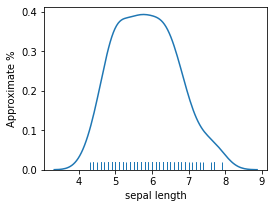

In [6]:
plt.subplots(1,1,figsize=(4,3))
ax = sns.distplot(iris_df['sepal length'], hist=False, rug=True)
ax.set_ylabel("Approximate %");

In [7]:
# sklearn으로 바이너리 임계값을 적용하는 것은 까다롭습니다.
column = iris_df[['sepal length']] # 2차원을 유지해야만 합니다.
col_mean = column.mean().values    # 시리즈나 데이터프레임은 취급하지 못합니다.

both = column.copy()
both['> Mean'] = skpre.binarize(column, col_mean).astype(np.bool)

print('Column Mean:', col_mean)
display(both.iloc[[0,50,100]])

Column Mean: [5.8433]


,sepal length,> Mean
0,5.1000,False
50,7.0000,True
100,6.3000,True


In [8]:
sep_len_series = iris_df['sepal length']
breaks = [sep_len_series.mean(), 
          sep_len_series.max()]

# 값을 추출하는 부분이 조금 지저분합니다.
print(pd.cut(sep_len_series, breaks).cat.codes[[0, 50, 100]])

0     -1
50     0
100    0
dtype: int8


In [9]:
# 쉬운 방법
np.where(column > column.mean(), True, False)[[0,50,100]]

array([[False],
       [ True],
       [ True]])

In [10]:
# 제가 말씀드린 형태의 문제를 풀기 위해 
# pandas를 이용해서 라벨이 달린 데이터프레임을 준비합니다.

new_iris_df = pd.DataFrame(iris_df, columns=['petal length', 
                                             'petal width', 
                                             'species'])

new_iris_df.columns = pd.MultiIndex([['input ftrs', 'target ftr'],
                                      new_iris_df.columns], 
                                     [[1, 0, 0], [0,1,2]])

new_iris_df.sort_index(axis='columns', inplace=True)
display(new_iris_df.iloc[[0,50,100]])

input ftrs                       target ftr
             petal width     species         petal length
0                 0.2000      setosa               1.4000
50                1.4000  versicolor               4.7000
100               2.5000   virginica               6.0000

In [11]:
# 카테고리 숫자로 시작합니다.
print("Numerical categories:",
      iris.target[[0, 50, 100]], sep='\n')

# 희소(sparse)한 형태로 만듭니다.
sparse = (skpre.OneHotEncoder(categories='auto')
               .fit_transform(iris.target.reshape(-1,1)))

# 빽빽한 형태로 만듭니다.
print("One-hot coding:", 
      sparse[[0,50,100]].todense(), sep="\n")

Numerical categories:
[0 1 2]
One-hot coding:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [12]:
# drop_first를 사용하면 트리트먼트 코딩을 할 수 있습니다.
encoded = pd.get_dummies(iris_df, prefix="is") 
encoded.iloc[[0,50,100]]

,sepal length,sepal width,petal length,petal width,is_setosa,is_versicolor,is_virginica
0,5.1000,3.5000,1.4000,0.2000,1,0,0
50,7.0000,3.2000,4.7000,1.4000,0,1,0
100,6.3000,3.3000,6.0000,2.5000,0,0,1


In [13]:
# merge를 이용해 데이터프레임 여럿을 접합합니다.
# `iris.target`은 setosa 등이 아닌 0, 1, 2로 기록되어 있습니다.
encoded_species = pd.get_dummies(iris.target)
encoded_df = pd.merge(iris_df, encoded_species, 
                      right_index=True, left_index=True)
encoded_df.iloc[[0,50,100]]

,sepal length,sepal width,petal length,petal width,species,0,1,2
0,5.1000,3.5000,1.4000,0.2000,setosa,1,0,0
50,7.0000,3.2000,4.7000,1.4000,versicolor,0,1,0
100,6.3000,3.3000,6.0000,2.5000,virginica,0,0,1


In [14]:
import patsy.contrasts as pc

levels = iris.target_names
coding = (pc.Treatment(reference=0)
            .code_with_intercept(list(levels)))
print(coding)

ContrastMatrix(array([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]]),
               ['[setosa]', '[versicolor]', '[virginica]'])


In [15]:
encoded = patsy.dmatrix('species-1', 
                        iris_df, 
                        return_type='dataframe')
display(encoded.iloc[[0,50,100]])

,species[setosa],species[versicolor],species[virginica]
0,1.0000,0.0000,0.0000
50,0.0000,1.0000,0.0000
100,0.0000,0.0000,1.0000


In [16]:
encoded = patsy.dmatrix('species', 
                        iris_df, 
                        return_type='dataframe')
display(encoded.iloc[[0,50,100]])

,Intercept,species[T.versicolor],species[T.virginica]
0,1.0000,0.0000,0.0000
50,1.0000,1.0000,0.0000
100,1.0000,0.0000,1.0000


In [17]:
pet_data = pd.DataFrame({'pet' :['cat', 'cat', 'dog'],
                         'cost':[20.0,   25.0,  40.0]})

pet_df = pd.get_dummies(pet_data)
display(pet_df)

,cost,pet_cat,pet_dog
0,20.0000,1,0
1,25.0000,1,0
2,40.0000,0,1


In [18]:
def pretty_coeffs(sk_lr_model, ftr_names):
    ' helper to display sklearn results in a nice dataframe '
    lr_coeffs = pd.DataFrame(sk_lr_model.coef_, 
                             columns=ftr_names, 
                             index=['Coeff'])
    lr_coeffs['intercept'] = sk_lr_model.intercept_
    return lr_coeffs

In [19]:
# 데이터 변형
sk_tgt  = pet_df['cost'].values.reshape(-1,1)
sk_ftrs = pet_df.drop('cost', axis='columns')

# 모델 제작
sk_model = (linear_model.LinearRegression(fit_intercept=False)
                       .fit(sk_ftrs, sk_tgt))
display(pretty_coeffs(sk_model, sk_ftrs.columns))

,pet_cat,pet_dog,intercept
Coeff,22.5000,40.0000,0.0000


In [20]:
import statsmodels as sm
import statsmodels.formula.api as smf

In [21]:
# 인터셉트를 명시적으로 제거하는 patsy 공식
formula = 'cost ~ pet - 1'
sm_model = smf.ols(formula, data=pet_data).fit()
display(pd.DataFrame(sm_model.params).T)

,pet[cat],pet[dog]
0,22.5000,40.0000


In [22]:
sk_tgt  = pet_df['cost'].values.reshape(-1,1)
sk_ftrs = pet_df.drop('cost', axis='columns')
sk_model = (linear_model.LinearRegression()   #  fit_intercept=True (기본값)
                       .fit(sk_ftrs, sk_tgt))
display(pretty_coeffs(sk_model, sk_ftrs.columns))

,pet_cat,pet_dog,intercept
Coeff,-8.7500,8.7500,31.2500


In [23]:
pet_data_p1 = pet_data.copy()  # 원본 데이터는 그대로 두세요
pet_data_p1['ones'] = 1.0      # 수동 플러스 원 트릭

# 인터셉트를 없애고 수동으로 1을 추가해 인터셉트를 다시 넣어줍니다.
formula = 'cost ~ (pet - 1)  + ones'
sm_model = smf.ols(formula, data=pet_data_p1).fit()
display(pd.DataFrame(sm_model.params).T)

,pet[cat],pet[dog],ones
0,1.6667,19.1667,20.8333


In [24]:
# 행 자르기는 조금 귀찮지만, 이렇게 하면 동일한 사례에 대한
# 여러 모델의 예측 결과를 비교할 수 있습니다. 
df = pd.DataFrame({'predicted_sk' : sk_model.predict(sk_ftrs)[:,0],
                  'predicted_sm' : sm_model.predict(pet_data_p1),
                  'actual'       : sk_tgt[:,0]})
display(df)

,predicted_sk,predicted_sm,actual
0,22.5000,22.5000,20.0000
1,22.5000,22.5000,25.0000
2,40.0000,40.0000,40.0000


In [25]:
display(pet_data_p1)

,pet,cost,ones
0,cat,20.0000,1.0000
1,cat,25.0000,1.0000
2,dog,40.0000,1.0000


In [26]:
print('pet - 1 coding')
print(patsy.dmatrix('pet - 1', data=pet_data_p1))

pet - 1 coding
[[1. 0.]
 [1. 0.]
 [0. 1.]]


In [27]:
# 코딩된 열들을 모두 더하면 어떻게 될까요?
print("column sum:")
full_coding = patsy.dmatrix('pet - 1', 
                            data=pet_data_p1, 
                            return_type='dataframe')
display(pd.DataFrame(full_coding.sum(axis='columns')))

column sum:


,0
0,1.0000
1,1.0000
2,1.0000


In [28]:
xor_data = [[0,0,0],
            [0,1,1],
            [1,0,1],
            [1,1,0]]
xor_df = pd.DataFrame(xor_data, 
                      columns=['x1','x2','tgt'])
display(xor_df)

,x1,x2,tgt
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [29]:
model = (linear_model.LogisticRegression()
                     .fit(xor_df[['x1', 'x2']], 
                          xor_df['tgt']))
model.predict(xor_df[['x1', 'x2']])

array([0, 0, 0, 0], dtype=int64)

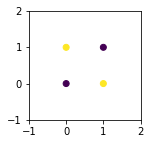

In [30]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
ax.scatter('x1', 'x2', data=xor_df, c='tgt')
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2);

In [31]:
xor_df['new'] = (-1)**xor_df['x1'] * (-1)**xor_df['x2']
xor_df

,x1,x2,tgt,new
0,0,0,0,1
1,0,1,1,-1
2,1,0,1,-1
3,1,1,0,1


In [32]:
model = linear_model.LogisticRegression().fit(xor_df[['new']], 
                                              xor_df['tgt'])
model.predict(xor_df[['new']])

array([0, 1, 1, 0], dtype=int64)

In [33]:
# 파라미터:
# degree: 항의 차수
# interaction_only:  x**2는 사용하지 않습니다. (x, y와) x*y만 씁니다.
# include_bias: 상수항
quad_inters = skpre.PolynomialFeatures(degree=2,              # 항의 차수
                                       interaction_only=True, # x*y만 사용
                                       include_bias=False)    # 상수항
subset = iris_df.loc[[0, 50, 100], ['sepal length', 'sepal width']]
new_terms = pd.DataFrame(quad_inters.fit_transform(subset), 
                         index=[0, 50, 100])
new_terms.set_axis(['sep length', 'sep width', 'sep area'], 
                   axis=1, inplace=True)

# 노트: 인터랙션 항을 만들면 인터랙션에 기본 항들도 포함됩니다.
display(new_terms)


,sep length,sep width,sep area
0,5.1000,3.5000,17.8500
50,7.0000,3.2000,22.4000
100,6.3000,3.3000,20.7900


In [34]:
design_df = patsy.dmatrix("Q('sepal length'):Q('sepal width') - 1", 
                          data=iris_df.iloc[[0, 50, 100]],
                          return_type='dataframe')
design_df

,Q('sepal length'):Q('sepal width')
0,17.8500
50,22.4000
100,20.7900


In [35]:
# 넓이를 구합니다.
sepal_area = iris_df['sepal length'] * iris_df['sepal width']
petal_area = iris_df['petal length'] * iris_df['petal width']

# 이산화합니다.
iris_df['big_sepal'] = sepal_area > sepal_area.median()
iris_df['big_petal'] = petal_area > petal_area.median()
display(iris_df.iloc[[0,50,100]])

,sepal length,sepal width,petal length,petal width,species,big_sepal,big_petal
0,5.1000,3.5000,1.4000,0.2000,setosa,True,False
50,7.0000,3.2000,4.7000,1.4000,versicolor,True,True
100,6.3000,3.3000,6.0000,2.5000,virginica,True,True


In [36]:
design_df = patsy.dmatrix("big_sepal:big_petal - 1", 
                          data=iris_df.iloc[[0, 50, 100]],
                          return_type='dataframe')

# 열 이름이 길어서 데이터프레임을 쪼갰습니다.
display(design_df.iloc[:, :2])
display(design_df.iloc[:,2: ])

,big_sepal[False]:big_petal[False],big_sepal[True]:big_petal[False]
0,0.0000,1.0000
50,0.0000,0.0000
100,0.0000,0.0000


,big_sepal[False]:big_petal[True],big_sepal[True]:big_petal[True]
0,0.0000,0.0000
50,0.0000,1.0000
100,0.0000,1.0000


In [37]:
# 열 이름에 공백이 있기 때문에 Q를 사용합니다.
design_df = patsy.dmatrix("C(species,Treatment):Q('sepal length') - 1", 
                        data=iris_df.iloc[[0, 50, 100]],
                        return_type='dataframe')

# 열 이름이 길어서 데이터 프레임을 쪼개어 출력합니다.
display(design_df.iloc[:,[0]])
display(design_df.iloc[:,[1]])
display(design_df.iloc[:,[2]])

,"C(species, Treatment)[setosa]:Q('sepal length')"
0,5.1000
50,0.0000
100,0.0000


,"C(species, Treatment)[versicolor]:Q('sepal length')"
0,0.0000
50,7.0000
100,0.0000


,"C(species, Treatment)[virginica]:Q('sepal length')"
0,0.0000
50,0.0000
100,6.3000


In [38]:
print(iris_df.iloc[[0, 50, 100]]['sepal length'])

0                   5.1000
50                  7.0000
100                 6.3000
Name: sepal length, dtype: float64


In [39]:
import statsmodels as sm
import statsmodels.formula.api as smf

In [40]:
# 설계행렬을 만들어 sklearn에 전달합니다.
design = "C(species,Treatment):petal_area"
design_matrix = patsy.dmatrix(design, data=iris_df)

# 인터셉트는 이미 설계행렬에 들어있습니다.
lr = linear_model.LinearRegression(fit_intercept=False) 
mod = lr.fit(design_matrix, iris_df['sepal width'])
print(mod.coef_)

[ 2.8378  1.402  -0.0034  0.0146]


In [41]:
# 같은 결과가 나왔습니다!
formula = "Q('sepal width') ~ C(species,Treatment):petal_area"
res1 = smf.ols(formula=formula, data=iris_df).fit()
print(res1.params)

Intercept                                                    2.8378
C(species, Treatment)[setosa]:petal_area                     1.4020
C(species, Treatment)[versicolor]:petal_area                -0.0034
C(species, Treatment)[virginica]:petal_area                  0.0146
dtype: float64


In [42]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]

area_df = pd.DataFrame({"sepal_area" : iris_df['sepal length'] * 
                                       iris_df['sepal width'],
                        "petal_area" : iris_df['petal length'] * 
                                       iris_df['petal width']})

In [43]:
def median_big_small(d):
    return d > np.median(d)

transformer = skpre.FunctionTransformer(median_big_small)
res = transformer.fit_transform(area_df)

print("Large areas as compared to median?")
print(res[[0, 50, 100]])

Large areas as compared to median?
[[ True False]
 [ True False]
 [ True  True]]


In [44]:
from sklearn.base import TransformerMixin
class Median_Big_Small(TransformerMixin):
    def __init__(self):
        pass
    def fit(self, ftrs, tgt=None):
        self.medians = np.median(ftrs)
        return self
    def transform(self, ftrs, tgt=None):
        return ftrs > self.medians

In [45]:
# 훈련-테스트 분리
training, testing = skms.train_test_split(area_df)
    
# 트랜스포머 생성하고 실행합니다.
transformer = Median_Big_Small()
train_xform = transformer.fit_transform(training)
test_xform  = transformer.transform(testing)

# 결과는 그대로 데이터프레임입니다.
print('train:')
display(train_xform[:3])
print('test:')
display(test_xform[ :3])

train:


,sepal_area,petal_area
39,True,False
142,True,False
64,True,False


test:


,sepal_area,petal_area
147,True,False
78,True,False
133,True,False


In [46]:
x = np.linspace(1,10,50)
n1 = np.random.normal(size=x.shape)

comparison = pd.DataFrame({"x"  : x,
                           "d1" : 2*x+5    + n1,
                           "d2" : 2*x**2+5 + n1})

comparison['x'] = x
melted = pd.melt(comparison, id_vars=['x'])

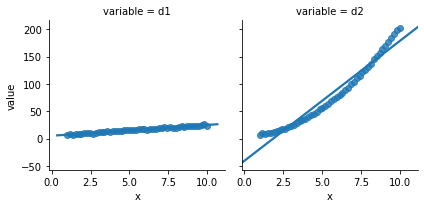

In [47]:
sns.lmplot(x='x', y='value',
           data=melted, col='variable', ci=None,
           height=3);

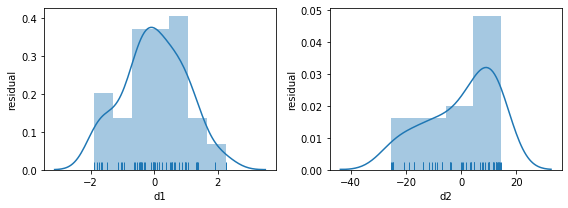

In [48]:
fig, axes = plt.subplots(1,2,figsize=(8,3))
for ax, variable in zip(axes, ['d1', 'd2']):
    predicted = (smf.ols("{} ~ x".format(variable), data=comparison)
                    .fit()
                    .predict())
    actual = comparison[variable]
    sns.distplot(predicted - actual, norm_hist=True, rug=True, ax=ax)
    ax.set_xlabel(variable)
    ax.set_ylabel('residual')
fig.tight_layout();

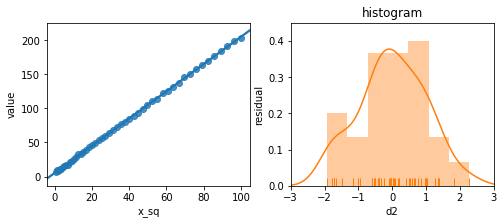

In [49]:
magic = pd.DataFrame({"d2"   : 2*x**2+5+n1,
                      "x_sq" : x**2})
melted = pd.melt(magic, id_vars=['x_sq'])

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3))
sns.regplot(x='x_sq', y='value', 
            data=melted, ci=None, ax=ax1)

predicted = (smf.ols("d2 ~ x_sq", data=magic)
                .fit()
                .predict())
actual = comparison['d2']
sns.distplot(predicted - actual, rug=True, 
             norm_hist = True, ax=ax2)

ax2.set_title('histogram')
ax2.set_xlim(-3,3)
ax2.set_ylim(0,.45)
ax2.set_ylabel('residual');

In [50]:
x = np.linspace(1,10,50)

n1 = np.random.normal(size=x.shape)
n2 = .5*x*np.random.normal(size=x.shape)

comparison = pd.DataFrame({"x"  : x,
                           "d1" : 2*x+5+n1,
                           "d2" : 2*x+5+n2})

comparison['x'] = x
melted = pd.melt(comparison, id_vars=['x'])

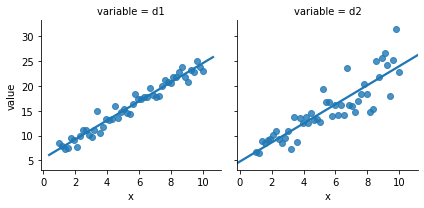

In [51]:
sns.lmplot(x='x', y='value', 
           data=melted, col='variable', ci=None,
           height=3);

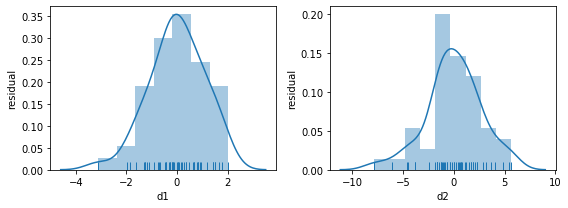

In [52]:
fig, axes = plt.subplots(1,2,figsize=(8,3))
for ax, variable in zip(axes, ['d1', 'd2']):
    predicted = (smf.ols("{} ~ x".format(variable), data=comparison)
                    .fit()
                    .predict())
    actual = comparison[variable]
    sns.distplot(predicted - actual, norm_hist=True, rug=True, ax=ax)
    ax.set_xlabel(variable)
    ax.set_ylabel('residual')

fig.tight_layout();

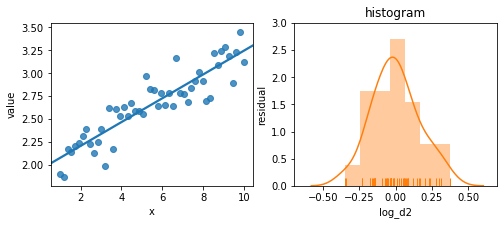

In [53]:
magic = pd.DataFrame({"log_d2" : np.log(comparison['d2']),
                      "x"      : x})
melted = pd.melt(magic, id_vars=['x'])

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3))
sns.regplot(x='x', y='value', data=melted, 
            ci=None, ax=ax1)

predicted = (smf.ols("log_d2 ~ x", data=magic)
                .fit()
                .predict())
actual = magic['log_d2']
sns.distplot(predicted - actual, rug=True, ax=ax2)

ax2.set_title('histogram')
ax2.set_xlim(-.7, .7)
ax2.set_ylim(0,3)
ax2.set_ylabel('residual');

In [54]:
x = np.linspace(1,8,100)
n1 = np.random.normal(size=x.shape)
n2 = x * np.random.normal(size=x.shape)

mystery = {'m1':5 + n1,
           'm2':5 + n2,
           'm3':x + n1,
           'm4':x + n2,
           'm5':np.log2(x) + n1,
           'm6':np.log2(x) + n2,
           'm7':np.exp2(x + n1),
           'm8':np.exp2(x + n2)}

mystery_df = pd.DataFrame(mystery)
mystery_df['x'] = x